In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as k
import tensorflow_addons as tfa
import tensorflow.keras.layers as kl
from tensorflow.keras import optimizers 
from tensorflow.keras import regularizers 
from tensorflow.keras import losses 
from tensorflow.keras import metrics as kmetrics
from sklearn import metrics as skmetrics
import matplotlib.pyplot as plt

from IPython.display import clear_output

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

from IPython import display
from datetime import datetime as dt

from data.utils import WindowDataset,WindowDatasetStack

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)
plt.rcParams["figure.figsize"] = (16, 8)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
   # Currently, memory growth needs to be the same across GPUs
   try:
       for gpu in gpus:
           tf.config.experimental.set_memory_growth(gpu, True)
   except RuntimeError as e:
       print(e)

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), markerscale=4, fontsize=18)        
        
%matplotlib inline

# Parameters

In [2]:
data_path = os.environ['ENGINE_FAULT_DETECTION_PROJECT_DATA_PATH']
models_path = os.environ['ENGINE_FAULT_DETECTION_PROJECT_MODELS_PATH']

class Bunch:
    __init__ = lambda self, **kw: setattr(self, '__dict__', kw)
args = Bunch()    

args.window_size = 1000
args.train_test_split_ratio = 0.9
args.portion = 1.0
args.batch_size = 2**7
args.epochs = 100
args.windows_per_epoch = int(1e6)
args.active_channels = 2
args.initial_learning_rate = 3e-4
args.decay = args.initial_learning_rate / args.epochs
args.warmup_steps = 1

model_name = 'DenseBN_10sec_mixed'
simulated_dataset_path = '../../data/4_states_sim.csv'
experiment_dataset_path = '../../data/4_states_exp.csv'

now = dt.now()
log_name = '{}_epochs_{}_{}_{}_{}.h5'.format(model_name, args.epochs, now.day, now.hour, now.minute)
hist_log_name = '{}_epochs_{}_{}_{}_{}.csv'.format(model_name, args.epochs, now.day, now.hour, now.minute)

In [3]:
def noam_based_decay(epoch, lr):
    epoch += 1    
    return args.initial_learning_rate * args.warmup_steps**0.5 * min(epoch**-0.5, epoch*(args.warmup_steps**-1.5)) 

# Dataset

In [4]:
simulated_dataset_description = pd.read_csv(simulated_dataset_path, skipinitialspace=True)
simulated_dataset_description

fp  cid                      name
0                    simulation/07.11.19_nominal.npy    0                 Исправная
1                   simulation/07.11.19_pga_leak.npy    1         Утечка газа в ПГА
2         simulation/09.12.20_fluid_leak_0.600mm.npy    2           Утечка жидкости
3         simulation/09.12.20_fluid_leak_0.625mm.npy    2           Утечка жидкости
4         simulation/09.12.20_fluid_leak_0.650mm.npy    2           Утечка жидкости
5         simulation/09.12.20_fluid_leak_0.675mm.npy    2           Утечка жидкости
6         simulation/09.12.20_fluid_leak_0.700mm.npy    2           Утечка жидкости
7         simulation/09.12.20_fluid_leak_0.725mm.npy    2           Утечка жидкости
8         simulation/09.12.20_fluid_leak_0.750mm.npy    2           Утечка жидкости
9         simulation/09.12.20_fluid_leak_0.775mm.npy    2           Утечка жидкости
10        simulation/09.12.20_fluid_leak_0.800mm.npy    2           Утечка жидкости
11        simulation/09.12.20_fluid_leak_0.825mm.npy    2           Утечка жидкости
12        simulation/09.12.20_fluid_leak_0.850mm.npy    2           Утечка жидкости
13        simulation/09.12.20_fluid_leak_0.875mm.npy    2           Утечка жидкости
14        simulation/09.12.20_fluid_leak_0.900mm.npy    2           Утечка жидкости
15        simulation/09.12.20_fluid_leak_0.925mm.npy    2           Утечка жидкости
16        simulation/25.12.20_fluid_leak_0.940mm.npy    2           Утечка жидкости
17        simulation/09.12.20_fluid_leak_0.950mm.npy    2           Утечка жидкости
18        simulation/09.12.20_fluid_leak_0.975mm.npy    2           Утечка жидкости
19        simulation/09.12.20_fluid_leak_1.000mm.npy    2           Утечка жидкости
20        simulation/09.12.20_fluid_leak_1.025mm.npy    2           Утечка жидкости
21        simulation/09.12.20_fluid_leak_1.050mm.npy    2           Утечка жидкости
22        simulation/09.12.20_fluid_leak_1.075mm.npy    2           Утечка жидкости
23        simulation/09.12.20_fluid_leak_1.100mm.npy    2           Утечка жидкости
24        simulation/09.12.20_fluid_leak_1.125mm.npy    2           Утечка жидкости
25        simulation/09.12.20_fluid_leak_1.150mm.npy    2           Утечка жидкости
26        simulation/25.12.20_fluid_leak_1.160mm.npy    2           Утечка жидкости
27        simulation/09.12.20_fluid_leak_1.175mm.npy    2           Утечка жидкости
28        simulation/09.12.20_fluid_leak_1.200mm.npy    2           Утечка жидкости
29        simulation/09.12.20_fluid_leak_1.225mm.npy    2           Утечка жидкости
30        simulation/09.12.20_fluid_leak_1.250mm.npy    2           Утечка жидкости
31        simulation/09.12.20_fluid_leak_1.275mm.npy    2           Утечка жидкости
32        simulation/09.12.20_fluid_leak_1.300mm.npy    2           Утечка жидкости
33        simulation/09.12.20_fluid_leak_1.325mm.npy    2           Утечка жидкости
34        simulation/09.12.20_fluid_leak_1.350mm.npy    2           Утечка жидкости
35        simulation/25.12.20_fluid_leak_1.365mm.npy    2           Утечка жидкости
36        simulation/09.12.20_fluid_leak_1.375mm.npy    2           Утечка жидкости
37        simulation/09.12.20_fluid_leak_1.400mm.npy    2           Утечка жидкости
38        simulation/09.12.20_fluid_leak_1.425mm.npy    2           Утечка жидкости
39        simulation/09.12.20_fluid_leak_1.450mm.npy    2           Утечка жидкости
40        simulation/09.12.20_fluid_leak_1.475mm.npy    2           Утечка жидкости
41        simulation/09.12.20_fluid_leak_1.500mm.npy    2           Утечка жидкости
42        simulation/09.12.20_fluid_leak_1.525mm.npy    2           Утечка жидкости
43        simulation/09.12.20_fluid_leak_1.550mm.npy    2           Утечка жидкости
44        simulation/25.12.20_fluid_leak_1.560mm.npy    2           Утечка жидкости
45        simulation/09.12.20_fluid_leak_1.575mm.npy    2           Утечка жидкости
46        simulation/09.12.20_fluid_leak_1.600mm.npy    2           Утечка жидкости
47        simulati

In [5]:
experiment_dataset_description = pd.read_csv(experiment_dataset_path, skipinitialspace=True)
experiment_dataset_description

fp  cid                      name
0                    experiment/06.11.19_nominal.npy    0                 Исправная
1   experiment/14.12.20_fluid_leak_nominal_state.npy    0                 Исправная
2    experiment/17.12.20_valve_set_error_nominal.npy    0                 Исправная
3    experiment/31.12.20_valve_set_error_nominal.npy    0                 Исправная
4                   experiment/06.11.19_pga_leak.npy    1         Утечка газа в ПГА
5         experiment/14.12.20_fluid_leak_0.940mm.npy    2           Утечка жидкости
6         experiment/14.12.20_fluid_leak_1.160mm.npy    2           Утечка жидкости
7         experiment/14.12.20_fluid_leak_1.365mm.npy    2           Утечка жидкости
8         experiment/14.12.20_fluid_leak_1.560mm.npy    2           Утечка жидкости
9   experiment/17.12.20_valve_set_error_15.20bar.npy    3  Ошибка настройки клапана
10  experiment/31.12.20_valve_set_error_15.20bar.npy    3  Ошибка настройки клапана
11  experiment/17.12.20_valve_set_error_22.30bar.npy    3  Ошибка настройки клапана
12  experiment/31.12.20_valve_set_error_22.30bar.npy    3  Ошибка настройки клапана
13  experiment/17.12.20_valve_set_error_29.30bar.npy    3  Ошибка настройки клапана
14  experiment/31.12.20_valve_set_error_29.30bar.npy    3  Ошибка настройки клапана
15  experiment/17.12.20_valve_set_error_36.10bar.npy    3  Ошибка настройки клапана
16  experiment/31.12.20_valve_set_error_36.10bar.npy    3  Ошибка настройки клапана

In [6]:
Xsim = WindowDataset(simulated_dataset_path, window_size=args.window_size, initial_shuffle=True, portion=args.portion, active_channels=args.active_channels, verbose=True)
Xexp = WindowDataset(experiment_dataset_path, window_size=args.window_size, initial_shuffle=True, portion=args.portion, active_channels=args.active_channels, verbose=True)
Xmix = WindowDatasetStack(Xsim, Xexp)

../../data/simulation/07.11.19_nominal.npy (3, 999200)
../../data/simulation/07.11.19_pga_leak.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.600mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.625mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.650mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.675mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.700mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.725mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.750mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.775mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.800mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.825mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.850mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.875mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.900mm.npy (3, 999200)
../../data/simulation/09.12.20_

In [7]:
assert Xsim.class_names == Xexp.class_names
class_names = Xsim.class_names
class_names

{0: 'Исправная',
 1: 'Утечка газа в ПГА',
 2: 'Утечка жидкости',
 3: 'Ошибка настройки клапана'}

In [8]:
Xmix_train_classifier = Xmix.get_generator(
    get_item=lambda cid, w: (w.T, (cid, cid)),
    get_types=lambda: (tf.float32, (tf.int8, tf.int8)),
    get_shape=lambda: (tf.TensorShape([args.window_size, args.active_channels]),  (tf.TensorShape([]), tf.TensorShape([]))),
    train=True, 
    shuffle_windows=True,
    kidx=0,
    train_test_split_ratio=[args.train_test_split_ratio, 0.5])

In [9]:
Xsim_test_classifier, test_labels_true = Xsim.get_generator(
    get_item=lambda cid, w: (w.T, ( cid, cid)),
    get_types=lambda: (tf.float32, ( tf.int8, tf.int8)),
    get_shape=lambda: (tf.TensorShape([args.window_size, args.active_channels]),  ( tf.TensorShape([]), tf.TensorShape([]))),
    train=False, 
    shuffle_windows=True,
    kidx=0,
    train_test_split_ratio=args.train_test_split_ratio,
    return_true_labels=True)

Xexp_test_classifier, experiment_labels_true = Xexp.get_generator(
    get_item=lambda cid, w: (w.T, ( cid, cid)),
    get_types=lambda: (tf.float32, ( tf.int8, tf.int8)),
    get_shape=lambda: (tf.TensorShape([args.window_size, args.active_channels]),  (tf.TensorShape([]), tf.TensorShape([]))),
    train=False, 
    shuffle_windows=False,
    kidx=0,
    train_test_split_ratio=0.5,
    return_true_labels=True)

# Model

In [10]:
input_shape = (Xsim.window_size, Xsim.active_channels)

inputs = k.Input(shape=input_shape)

c1 = kl.Conv1D(filters=100, kernel_size=3, activation='tanh')(inputs)
c2 = kl.Conv1D(filters=140, kernel_size=3, activation='tanh')(c1)
mp1 = kl.MaxPooling1D(2)(c2)
f = kl.Flatten()(mp1)
dropout = kl.Dropout(0.2)(f)
dense1 = kl.Dense(900, activation='tanh')(dropout)

softmax_output = kl.Dense(Xsim.number_of_classes, activation='softmax', name='softmax_layer')(dense1)
label_output = kl.Lambda(lambda x: k.backend.argmax(x), name='label_layer')(softmax_output)

classifier_model = k.Model(inputs=inputs, outputs=[softmax_output, label_output])
classifier_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000, 2)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 998, 100)          700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 140)          42140     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 498, 140)          0         
_________________________________________________________________
flatten (Flatten)            (None, 69720)             0         
_________________________________________________________________
dropout (Dropout)            (None, 69720)             0         
_________________________________________________________________
dense (Dense)                (None, 900)               627489

# Train

In [11]:
class History:
    def __init__(self, path):
        self.path = path
        self.train_loss = []
        self.train_classifier_loss = []
        self.train_classifier_acc = []
        
        self.test_loss = []
        self.test_classifier_loss = []
        self.test_classifier_acc = []
        
        self.experiment_loss = []
        self.experiment_classifier_loss = []
        self.experiment_classifier_acc = []

        
    def save_state(self):
        df = pd.DataFrame({i:d[i] for i in self.__dict__ if i != 'path'})
        df.to_csv(self.path, index=False)
    
    def load_state(self):
        df = pd.read_csv(self.path)
        for c in df.columns:
            self.__dict__[c] = df[c].to_list()
        
history = History(hist_log_name)

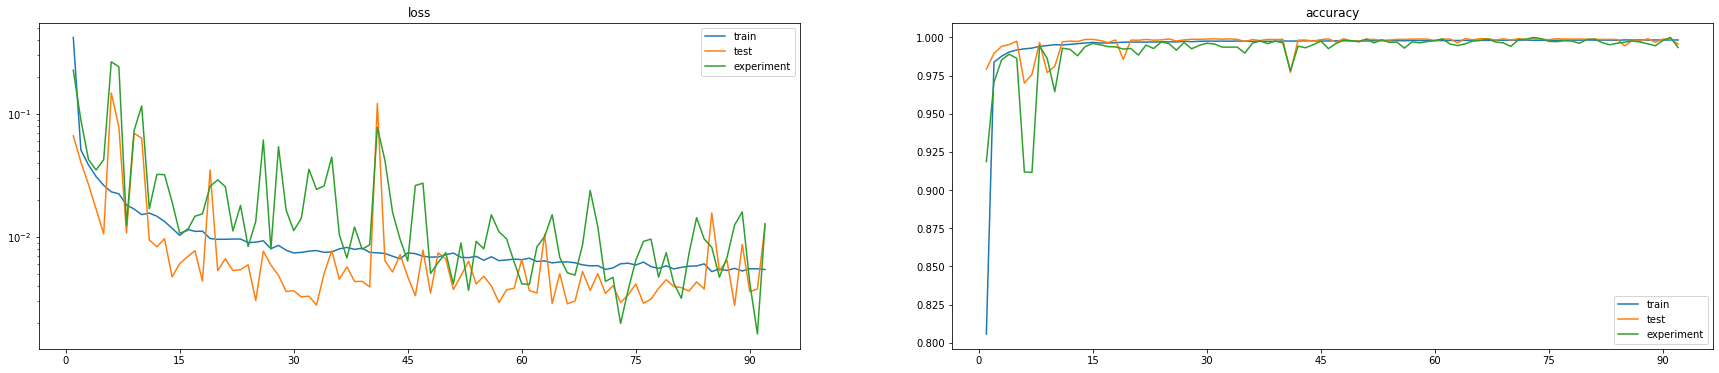

10:51:31.668728 92/100
train_loss: 0.0054377, test_loss:0.0123010, exp_loss:0.0128125
train_acc: 99.84, test_acc:99.56, test_acc:99.3369162
Epoch 93/100

Epoch 00093: LearningRateScheduler reducing learning rate to 3.1108550841912754e-05.
1072/7813 [===>..........................] - ETA: 6:11 - loss: 0.0052 - softmax_layer_loss: 0.0052 - softmax_layer_sparse_categorical_accuracy: 0.9984

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



7739/7813 [============================>.] - ETA: 4s - loss: 0.0049 - softmax_layer_loss: 0.0049 - softmax_layer_sparse_categorical_accuracy: 0.9985

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



6915/7813 [=========================>....] - ETA: 49s - loss: 0.0054 - softmax_layer_loss: 0.0054 - softmax_layer_sparse_categorical_accuracy: 0.9983

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



6083/7813 [======================>.......] - ETA: 1:35 - loss: 0.0046 - softmax_layer_loss: 0.0046 - softmax_layer_sparse_categorical_accuracy: 0.9986

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



5280/7813 [===================>..........] - ETA: 2:19 - loss: 0.0051 - softmax_layer_loss: 0.0051 - softmax_layer_sparse_categorical_accuracy: 0.9985

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [12]:
%%time 

start_time = dt.now()

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(30,6), gridspec_kw={'width_ratios':[0.5, 0.5]})

samples = max(10000, int(min(Xsim.number_of_windows*0.1, Xexp.number_of_windows*0.1)))

callbacks = []
class DrawingCallback(k.callbacks.Callback):
    def __init__(self, history):
        self.history = history
        self.train_sample = Xmix_train_classifier.take(samples)
        self.test_sample = Xsim_test_classifier.take(samples)
        self.experiment_sample = Xexp_test_classifier.take(samples)
    
    def on_epoch_end(self, epoch, logs={}):
        train_results = logs
        train_loss, train_classifier_acc = train_results['loss'], train_results['softmax_layer_sparse_categorical_accuracy']
        
        test_results = classifier_model.evaluate(self.test_sample.batch(args.batch_size), return_dict=True)
        test_loss, test_classifier_acc = test_results['loss'], test_results['softmax_layer_sparse_categorical_accuracy']
        
        experiment_results = classifier_model.evaluate(self.experiment_sample.batch(args.batch_size), return_dict=True)
        experiment_loss, experiment_classifier_acc = experiment_results['loss'], experiment_results['softmax_layer_sparse_categorical_accuracy']
        
        self.history.train_loss.append(train_loss)
        self.history.train_classifier_acc.append(train_classifier_acc)
        self.history.test_loss.append(test_loss)
        self.history.test_classifier_acc.append(test_classifier_acc)
        self.history.experiment_loss.append(experiment_loss)
        self.history.experiment_classifier_acc.append(experiment_classifier_acc)
        
        ax1.cla()
        ax2.cla()
        
        ax1.set_title("loss")
        ax2.set_title("accuracy")
        
        ax1.set_yscale('log')
  
        ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax1.plot(range(1, len(self.history.train_loss)+1), self.history.train_loss, label='train')
        ax1.plot(range(1, len(self.history.test_loss)+1), self.history.test_loss, label='test')
        ax1.plot(range(1, len(self.history.experiment_loss)+1), self.history.experiment_loss, label='experiment')
        ax1.legend()        
    
        ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax2.plot(range(1, len(self.history.train_classifier_acc)+1), self.history.train_classifier_acc, label='train')
        ax2.plot(range(1, len(self.history.test_classifier_acc)+1), self.history.test_classifier_acc, label='test')
        ax2.plot(range(1, len(self.history.experiment_classifier_acc)+1), self.history.experiment_classifier_acc, label='experiment')
        ax2.legend()
        

        display.clear_output(wait=True)
        display.display(fig)
        print("{} {}/{}".format(dt.now()-start_time, epoch+1, args.epochs))
        print("train_loss: {:.7f}, test_loss:{:.7f}, exp_loss:{:.7f}".format(self.history.train_loss[-1], 
                                                                             self.history.test_loss[-1],
                                                                             self.history.experiment_loss[-1]))
        print("train_acc: {:.2f}, test_acc:{:.2f}, test_acc:{:.7f}".format(self.history.train_classifier_acc[-1]*100, 
                                                                           self.history.test_classifier_acc[-1]*100,
                                                                           self.history.experiment_classifier_acc[-1]*100))


callbacks.append(DrawingCallback(history))

tensorboard_logs_dir = os.environ['ENGINE_FAULT_DETECTION_PROJECT_LOGS_PATH'] + 'tensorboard/'

log_dir = tensorboard_logs_dir + log_name
callbacks.append(k.callbacks.TensorBoard(log_dir=log_dir + '', histogram_freq=1))

callbacks.append(k.callbacks.LearningRateScheduler(noam_based_decay, verbose=1))
opt = optimizers.Adam(learning_rate=args.initial_learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

classifier_model.compile(optimizer=opt, 
                          loss={'softmax_layer':losses.SparseCategoricalCrossentropy()}, 
                          loss_weights={'softmax_layer':1.0, 'label_layer':0.0},
                          metrics={
                             'softmax_layer': kmetrics.SparseCategoricalAccuracy(),
                          }
                         )

classifier_model.fit(Xmix_train_classifier.take(args.windows_per_epoch).batch(args.batch_size), epochs=args.epochs,  verbose=1, callbacks=callbacks)

In [21]:
classifier_model.save(models_path + model_name + '_c.h5')

# Test

In [13]:
%%time

test_probs_predicted, test_labels_predicted = classifier_model.predict(Xsim_test_classifier.batch(args.batch_size))

CPU times: user 16min 29s, sys: 1min, total: 17min 30s
Wall time: 13min 9s


In [14]:
%%time

experiment_probs_predicted, experiment_labels_predicted = classifier_model.predict(Xexp_test_classifier.batch(args.batch_size))

CPU times: user 9.63 s, sys: 493 ms, total: 10.1 s
Wall time: 7.62 s


In [18]:
cf = confusion_matrix(test_labels_true, test_labels_predicted, normalize=None)

df_cm = pd.DataFrame(cf, index = class_names.values(), columns = class_names.values())

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0)
plt.xlabel('Predicted')
plt.title("Симуляционные данные\n\n" + classification_report(test_labels_true, test_labels_predicted, target_names=class_names.values()), loc="right")

Text(1.0, 1.0, 'Симуляционные данные\n\n                          precision    recall  f1-score   support\n\n               Исправная       0.99      0.93      0.96     99821\n       Утечка газа в ПГА       1.00      1.00      1.00     99821\n         Утечка жидкости       1.00      1.00      1.00   5290513\nОшибка настройки клапана       1.00      1.00      1.00   3593556\n\n                accuracy                           1.00   9083711\n               macro avg       1.00      0.98      0.99   9083711\n            weighted avg       1.00      1.00      1.00   9083711\n')

In [20]:
cf = confusion_matrix(experiment_labels_true, experiment_labels_predicted, normalize=None)

df_cm = pd.DataFrame(cf, index = class_names.values(), columns = class_names.values())

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0)
plt.xlabel('Predicted')
plt.title("Экспериментальные данные\n\n" + classification_report(experiment_labels_true, experiment_labels_predicted, target_names=class_names.values()), loc="right")

Text(1.0, 1.0, 'Экспериментальные данные\n\n                          precision    recall  f1-score   support\n\n               Исправная       1.00      1.00      1.00     23486\n       Утечка газа в ПГА       1.00      1.00      1.00      9986\n         Утечка жидкости       0.98      1.00      0.99     10000\nОшибка настройки клапана       1.00      1.00      1.00     44000\n\n                accuracy                           1.00     87472\n               macro avg       1.00      1.00      1.00     87472\n            weighted avg       1.00      1.00      1.00     87472\n')

In [ ]:
def custom_classification_report(true, predicted, class_names):
    class_labels = sorted(set(true))
    report_rows = []
    for cid in class_labels:
        class_true = true.copy()
        class_true[true!=cid] = 0
        class_true[true==cid] = 1
        class_predicted = predicted.copy()
        class_predicted[predicted!=cid] = 0
        class_predicted[predicted==cid] = 1
        
        accuracy = skmetrics.accuracy_score(class_true, class_predicted)
        balanced_accuracy = skmetrics.balanced_accuracy_score(class_true, class_predicted)
        precision = skmetrics.precision_score(class_true, class_predicted, average='binary')
        recall = skmetrics.recall_score(class_true, class_predicted, average='binary')
        f1 = skmetrics.f1_score(class_true, class_predicted, average='binary')
        mcc = skmetrics.matthews_corrcoef(class_true, class_predicted)
        report_rows.append([accuracy*100, balanced_accuracy*100, precision, recall, f1, mcc])
    
    accuracy = skmetrics.accuracy_score(true, predicted)
    balanced_accuracy = skmetrics.balanced_accuracy_score(true, predicted)
    precision = skmetrics.precision_score(true, predicted, average='macro')
    recall = skmetrics.recall_score(true, predicted, average='macro')
    f1 = skmetrics.f1_score(true, predicted, average='macro')
    mcc = skmetrics.matthews_corrcoef(true, predicted)
    report_rows.append([accuracy*100, balanced_accuracy*100, precision, recall, f1, mcc])
    
    report = pd.DataFrame(
        report_rows, 
        columns=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'MCC'],
        index=class_names + ['Total'] )
    
    return report

In [23]:
%%time
custom_classification_report(test_labels_true, test_labels_predicted, class_names=list(class_names.values()))

CPU times: user 1min 10s, sys: 0 ns, total: 1min 10s
Wall time: 1min 10s


accuracy  balanced_accuracy  precision    recall        f1       MCC
Исправная                 99.918580          96.529660   0.994934  0.930646  0.961717  0.961854
Утечка газа в ПГА         99.997358          99.879785   1.000000  0.997596  0.998796  0.998784
Утечка жидкости           99.991061          99.989517   0.999858  0.999989  0.999923  0.999816
Ошибка настройки клапана  99.912679          99.923109   0.998065  0.999731  0.998897  0.998175
Total                     99.909839          98.199026   0.998214  0.981990  0.989833  0.998211

In [24]:
%%time
custom_classification_report(experiment_labels_true, experiment_labels_predicted, class_names=list(class_names.values()))

accuracy  balanced_accuracy  precision    recall        f1       MCC
Исправная                  99.961130          99.927616   1.000000  0.998552  0.999276  0.999011
Утечка газа в ПГА         100.000000         100.000000   1.000000  1.000000  1.000000  1.000000
Утечка жидкости            99.820514          99.898673   0.984543  1.000000  0.992211  0.991235
Ошибка настройки клапана   99.781644          99.782485   0.999225  0.996432  0.997827  0.995637
Total                      99.781644          99.874604   0.995942  0.998746  0.997328  0.996642